### Wrinkle Detection
#### U-net w. f-1 loss

In [1]:
import torch
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memoy_cached())

4
GeForce GTX 1080 Ti
True


In [2]:
import argparse

import os
import csv
import datetime
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from unet.model import UNet
from unet.dataset import *
from unet.util import *
from unet.train import train
from unet.evaluate import evaluate
from unet.loss import f1_loss, weighted_loss_and_f1_loss

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def print_log(lr, batch_size, num_epoch, loss_name, data_dir, ckpt_dir, log_dir, mode, device, train_continue):
    time = datetime.datetime.today()
    time = time.strftime('%m-%d_%H-%M')
    time_and_loss = time + "_" + loss_name
    if ckpt_dir == "./checkpoint":
        ckpt_dir = os.path.join(ckpt_dir, time_and_loss)
    log_dir = os.path.join(log_dir, time_and_loss)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
        
    print(f'tensorboard --logdir {log_dir} --host "warhol1.snu.ac.kr" --port 6006')
    
    # log parameters
    print("learning rate: %.4e" % lr)
    print("batch size: %d" % batch_size)
    print("number of epoch: %d" % num_epoch)
    print("loss function : %s" % loss_name)
    print("data dir: %s" % data_dir)
    print("ckpt dir: %s" % ckpt_dir)
    print("log dir: %s" % log_dir)
    print("mode: %s" % mode)
    print("device: %s" % device)
    print("train_continue: %s" % train_continue)
    f = open(os.path.join(log_dir, 'parameter.txt'), 'w')
    f.write("learning rate: %.4e\n" % lr)
    f.write("batch size: %d\n" % batch_size)
    f.write("number of epoch: %d\n" % num_epoch)
    f.write("loss function : %s\n" % loss_name)
    f.write("data dir: %s\n" % data_dir)
    f.write("ckpt dir: %s\n" % ckpt_dir)
    f.write("log dir: %s\n" % log_dir)
    f.write("mode: %s\n" % mode)
    f.write("device: %s\n" % device)
    f.write("train_continue: %s\n" % train_continue)
    f.close()
    return log_dir

In [5]:
def train_unet(data_dir, loss_name='weighted_BCE', lr=1e-3, batch_size=8, num_epoch=300, ckpt_dir="./checkpoint", log_dir="./log", mode="train", train_continue="off"):
    
    train_transform = transforms.Compose([RandomResizedCrop(ratio=0.3), Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
    val_transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

    dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

    dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=val_transform)
    loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

    num_data_train = len(dataset_train)
    num_data_val = len(dataset_val)

    num_batch_train = np.ceil(num_data_train / batch_size)
    num_batch_val = np.ceil(num_data_val / batch_size)

    
    if loss_name == "BCE":
        loss_function = nn.BCEWithLogitsLoss().to(device)
    elif loss_name == "weighted_BCE":
        loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5])).to(device)  # 237 - > 59 -> 15
    elif loss_name == "f1":
        loss_function = f1_loss
    elif loss_name =="mix":
        mix_class = weighted_loss_and_f1_loss(nn.BCEWithLogitsLoss(pos_weight=torch.tensor([15])).to(device))
        loss_function = mix_class.loss
    else:
        assert False, loss_name + " is not supported"
        
    log_dir = print_log(lr, batch_size, num_epoch, loss_name, data_dir, ckpt_dir, log_dir, mode, device, train_continue)
        
    net = UNet()
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)
    
    optim = torch.optim.Adam(net.parameters(), lr=lr)

    writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
    writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

    train_f = open(os.path.join(log_dir, 'train.tsv'), 'w', encoding='utf-8', newline='')
    train_wr = csv.writer(train_f, delimiter='\t')
    val_f = open(os.path.join(log_dir, 'val.tsv'), 'w', encoding='utf-8', newline='')
    val_wr = csv.writer(val_f, delimiter='\t')
    train_wr.writerow(["#epoch/loss/acc/f1/tp/tn/fp/fn"])
    val_wr.writerow(["#epoch/loss/acc/f1/tp/tn/fp/fn"])

    ## train network
    st_epoch = 0

    if train_continue == "on":
        net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

    for epoch in range(st_epoch, st_epoch + num_epoch):
        net.train()
        loss, acc, f1, tp, tn, fp, fn = train(net, loader_train, loss_function, num_batch_train, epoch, writer_train, device, optim)
        train_wr.writerow((epoch, loss, acc, f1, tp, tn, fp, fn))

        loss, acc, f1, tp, tn, fp, fn = evaluate(net, loader_val, loss_function, num_batch_val, epoch, writer_val, device)
        val_wr.writerow((epoch, loss, acc, f1, tp, tn, fp, fn))

        if ((epoch+1) % (num_epoch / 10)) == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch+1)
        print("------------------------------------------------------------")

    writer_train.close()
    writer_val.close()
    train_f.close()
    val_f.close()
    
    return net, log_dir

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn

def plot_f1(logs):
    markers = ("o", "x", "s", "^")
    colors = ('dodgerblue','mediumseagreen', 'hotpink', '#fba84a')
    
    def plot_train():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('F1 Score - Train', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[3].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[3].to_numpy()
            plt.plot(train, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('f1 score', fontsize=15)
        plt.show()
    def plot_val():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('F1 Score - Validation', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[3].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[3].to_numpy()
            plt.plot(val, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('f1 score', fontsize=15)
        plt.show()
    plot_train()
    plot_val()
    
def plot_loss(logs):
    markers = ("o", "x", "s", "^")
    colors = ('dodgerblue','mediumseagreen', 'hotpink', '#fba84a')
    
    def plot_train():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('Loss - Train', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[1].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[1].to_numpy()
            plt.plot(train, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('loss', fontsize=15)
        plt.show()
    def plot_val():
        plt.rcParams["figure.figsize"] = (16,4)
        plt.rcParams['lines.linewidth'] = 2
        plt.rcParams['lines.color'] = 'r'
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False

        plt.suptitle('Loss - Validation', fontsize=20)

        for i, k in enumerate(logs):
            # epoch/loss/acc/f1/tp/tn/fp/fn
            df = pd.read_csv(f"{logs[k]}/val.tsv", delimiter='\t', header=None, skiprows=1)
            val = df[1].to_numpy()
            df = pd.read_csv(f"{logs[k]}/train.tsv", delimiter='\t', header=None, skiprows=1)
            train = df[1].to_numpy()
            plt.plot(val, color=colors[i], marker=markers[i])
        plt.legend(logs.keys(), fontsize=15)
        plt.xlabel('epoch', fontsize=15)
        plt.ylabel('loss', fontsize=15)
        plt.show()
    plot_train()
    plot_val()

### U-net baseline
* `train_unet(data_dir, loss_name)`
  * Loss function: `BCE`, `weight_BCE`, `f1`, `mix`

### ***Eye***
![](../data/eye_data/train/0014_f_58_20_brow_lower_tex_l.jpg)
![](../data/eye_data/train/0014_f_58_20_brow_lower_tex_r.jpg)
#### num_epoch as 10
* `tensorboard --logdir ./log/11-30_14-52_BCE --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_15-00_weighted_BCE --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_15-04_f1 --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_15-07_mix --host "warhol1.snu.ac.kr" --port 6006`

In [7]:
eye_logs = {}
eye_models = {}

In [8]:
for loss in ('BCE', 'weighted_BCE', 'f1', 'mix'):
    eye_models[loss], eye_logs[loss] = train_unet("../data/eye_data/", loss, num_epoch=200, batch_size=50)

tensorboard --logdir ./log/11-30_23-40_BCE --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 50
number of epoch: 1
loss function : BCE
data dir: ../data/eye_data/
ckpt dir: ./checkpoint/11-30_23-40_BCE
log dir: ./log/11-30_23-40_BCE
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0018 | LOSS 0.8683 | ACC 0.7449 | F1 SCORE 0.0498 | TIME 11.9909
TRAIN: EPOCH 0000 | BATCH 0002 / 0018 | LOSS 0.8331 | ACC 0.6682 | F1 SCORE 0.0556 | TIME 12.4939
TRAIN: EPOCH 0000 | BATCH 0003 / 0018 | LOSS 0.7407 | ACC 0.9396 | F1 SCORE 0.0491 | TIME 12.9563
TRAIN: EPOCH 0000 | BATCH 0004 / 0018 | LOSS 0.6662 | ACC 0.9391 | F1 SCORE 0.0526 | TIME 13.4242
TRAIN: EPOCH 0000 | BATCH 0005 / 0018 | LOSS 0.6078 | ACC 0.9460 | F1 SCORE 0.0549 | TIME 13.8780
TRAIN: EPOCH 0000 | BATCH 0006 / 0018 | LOSS 0.5481 | ACC 0.9553 | F1 SCORE 0.0485 | TIME 14.3436
TRAIN: EPOCH 0000 | BATCH 0007 / 0018 | LOSS 0.5259 | ACC 0.9610 | F1 SCORE 0.0497 | TIME 14.8894
TRAIN: EP

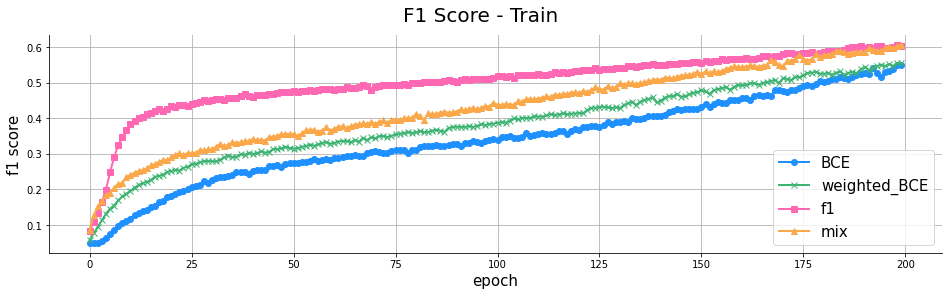

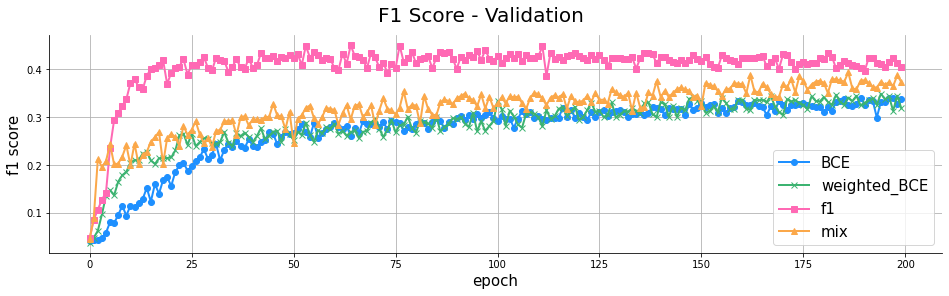

In [9]:
eye_logs['BCE'] = "./log/11-30_17-26_BCE"
eye_logs['weighted_BCE'] = "./log/11-30_18-34_weighted_BCE"
eye_logs['f1'] = "./log/11-30_19-41_f1"
eye_logs['mix'] = "./log/11-30_20-49_mix"

plot_f1(eye_logs)

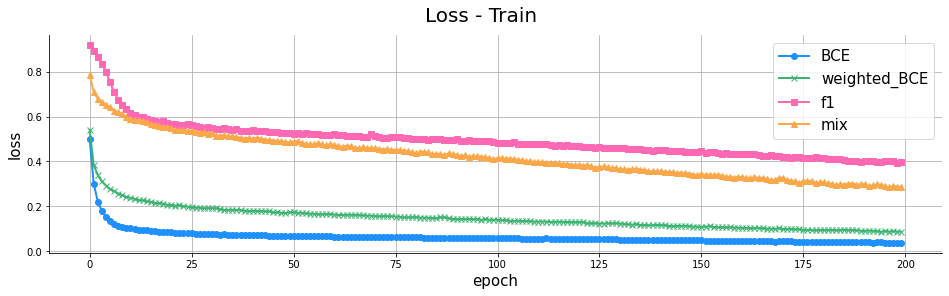

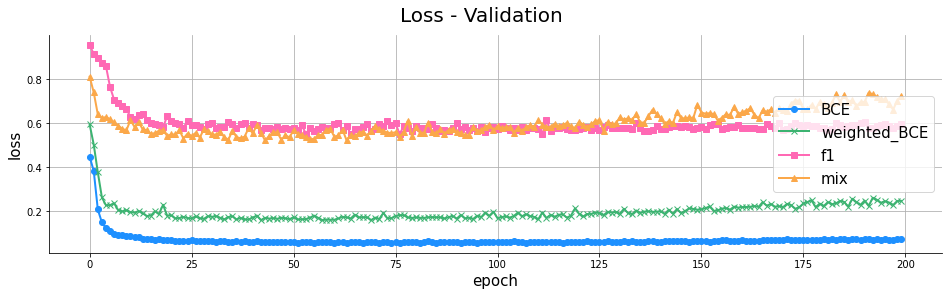

In [10]:
plot_loss(eye_logs)

### ***Upper Face***
![](../data/upper_face_data/train/0005_f_45_18_eye_closed_tex.jpg)
#### num_epoch as 10
* `tensorboard --logdir ./log/11-30_15-20_BCE --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_15-29_weighted_BCE --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_15-35_f1 --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_15-43_mix --host "warhol1.snu.ac.kr" --port 6006`

In [11]:
upper_logs = {}
upper_models = {}

In [ ]:
for loss in ('BCE', 'weighted_BCE', 'f1', 'mix'):
    upper_models[loss], upper_logs[loss] = train_unet("../data/upper_face_data/", loss, num_epoch=200, batch_size=10)

tensorboard --logdir ./log/11-30_23-52_BCE --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 10
number of epoch: 200
loss function : BCE
data dir: ../data/eye_data/
ckpt dir: ./checkpoint/11-30_23-52_BCE
log dir: ./log/11-30_23-52_BCE
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0088 | LOSS 0.6834 | ACC 0.9299 | F1 SCORE 0.0377 | TIME 11.2657
TRAIN: EPOCH 0000 | BATCH 0002 / 0088 | LOSS 0.6484 | ACC 0.8696 | F1 SCORE 0.0536 | TIME 11.4258
TRAIN: EPOCH 0000 | BATCH 0003 / 0088 | LOSS 0.5970 | ACC 0.9645 | F1 SCORE 0.0433 | TIME 11.5861
TRAIN: EPOCH 0000 | BATCH 0004 / 0088 | LOSS 0.5498 | ACC 0.9560 | F1 SCORE 0.0586 | TIME 11.7276
TRAIN: EPOCH 0000 | BATCH 0005 / 0088 | LOSS 0.5103 | ACC 0.9533 | F1 SCORE 0.0592 | TIME 11.8685
TRAIN: EPOCH 0000 | BATCH 0006 / 0088 | LOSS 0.4748 | ACC 0.9613 | F1 SCORE 0.0486 | TIME 12.0099
TRAIN: EPOCH 0000 | BATCH 0007 / 0088 | LOSS 0.4458 | ACC 0.9456 | F1 SCORE 0.0735 | TIME 12.1635
TRAIN: 

In [16]:
upper_logs

{'BCE': './log/11-30_23-52_BCE',
 'weighted_BCE': './log/12-01_00-48_weighted_BCE',
 'f1': './log/12-01_01-44_f1',
 'mix': './log/12-01_02-40_mix'}

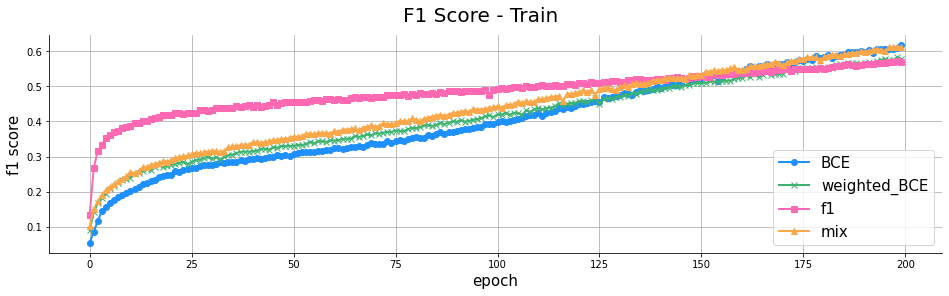

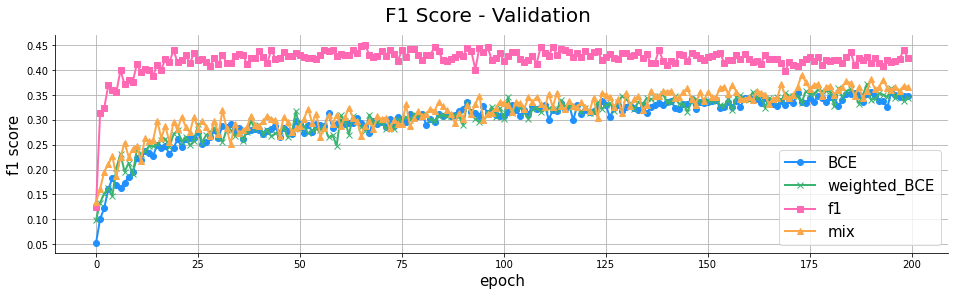

In [17]:
plot_f1(upper_logs)

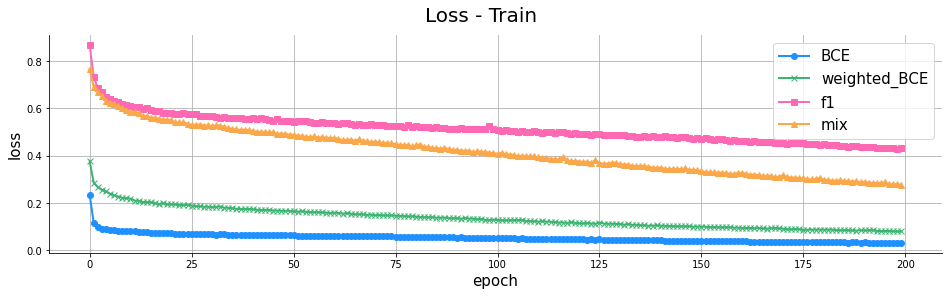

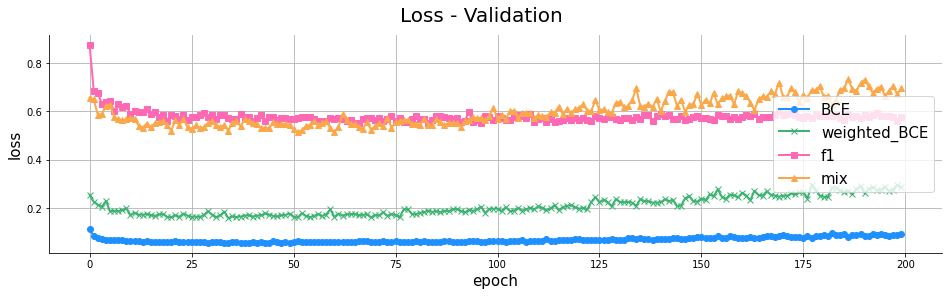

In [18]:
plot_loss(upper_logs)

### ***Lower Face***
![](../data/lower_face_data/train/0017_m_31_17_cheek_blowing_tex.jpg)

#### num_epoch as 10
* `tensorboard --logdir ./log/11-30_16-18_f1 --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_16-08_weighted_BCE --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_16-18_f1 --host "warhol1.snu.ac.kr" --port 6006`
* `tensorboard --logdir ./log/11-30_16-28_mix --host "warhol1.snu.ac.kr" --port 6006`

In [6]:
train_unet("../data/lower_face_data/", 'BCE', num_epoch=10, batch_size=5)

tensorboard --logdir ./log/11-30_15-56_BCE --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 5
number of epoch: 10
loss function : BCE
data dir: ../data/lower_face_data/
ckpt dir: ./checkpoint/11-30_15-56_BCE
log dir: ./log/11-30_15-56_BCE
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0088 | LOSS 0.9122 | ACC 0.7417 | F1 SCORE 0.0156 | TIME 9.7058
TRAIN: EPOCH 0000 | BATCH 0002 / 0088 | LOSS 0.8469 | ACC 0.7986 | F1 SCORE 0.0093 | TIME 10.5053
TRAIN: EPOCH 0000 | BATCH 0003 / 0088 | LOSS 0.7892 | ACC 0.9240 | F1 SCORE 0.0114 | TIME 11.1075
TRAIN: EPOCH 0000 | BATCH 0004 / 0088 | LOSS 0.6867 | ACC 0.9489 | F1 SCORE 0.0196 | TIME 11.7130
TRAIN: EPOCH 0000 | BATCH 0005 / 0088 | LOSS 0.6485 | ACC 0.9666 | F1 SCORE 0.0142 | TIME 12.3060
TRAIN: EPOCH 0000 | BATCH 0006 / 0088 | LOSS 0.5991 | ACC 0.9754 | F1 SCORE 0.0133 | TIME 12.9055
TRAIN: EPOCH 0000 | BATCH 0007 / 0088 | LOSS 0.5538 | ACC 0.9857 | F1 SCORE 0.0107 | TIME 13.5217
TRA

In [6]:
train_unet("../data/lower_face_data/", 'weighted_BCE', num_epoch=10, batch_size=5)

tensorboard --logdir ./log/11-30_16-08_weighted_BCE --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 5
number of epoch: 10
loss function : weighted_BCE
data dir: ../data/lower_face_data/
ckpt dir: ./checkpoint/11-30_16-08_weighted_BCE
log dir: ./log/11-30_16-08_weighted_BCE
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0088 | LOSS 0.7785 | ACC 0.9465 | F1 SCORE 0.0141 | TIME 10.2105
TRAIN: EPOCH 0000 | BATCH 0002 / 0088 | LOSS 0.7436 | ACC 0.9328 | F1 SCORE 0.0132 | TIME 10.9941
TRAIN: EPOCH 0000 | BATCH 0003 / 0088 | LOSS 0.6706 | ACC 0.9657 | F1 SCORE 0.0087 | TIME 11.6133
TRAIN: EPOCH 0000 | BATCH 0004 / 0088 | LOSS 0.6206 | ACC 0.9714 | F1 SCORE 0.0149 | TIME 12.2241
TRAIN: EPOCH 0000 | BATCH 0005 / 0088 | LOSS 0.5726 | ACC 0.9889 | F1 SCORE 0.0094 | TIME 12.8368
TRAIN: EPOCH 0000 | BATCH 0006 / 0088 | LOSS 0.5398 | ACC 0.9909 | F1 SCORE 0.0115 | TIME 13.4400
TRAIN: EPOCH 0000 | BATCH 0007 / 0088 | LOSS 0.5078 | ACC 0.9895

In [7]:
train_unet("../data/lower_face_data/", 'f1', num_epoch=10, batch_size=5)

tensorboard --logdir ./log/11-30_16-18_f1 --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 5
number of epoch: 10
loss function : f1
data dir: ../data/lower_face_data/
ckpt dir: ./checkpoint/11-30_16-18_f1
log dir: ./log/11-30_16-18_f1
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0088 | LOSS 0.9917 | ACC 0.9489 | F1 SCORE 0.0083 | TIME 2.0841
TRAIN: EPOCH 0000 | BATCH 0002 / 0088 | LOSS 0.9876 | ACC 0.6589 | F1 SCORE 0.0124 | TIME 2.6906
TRAIN: EPOCH 0000 | BATCH 0003 / 0088 | LOSS 0.9821 | ACC 0.6384 | F1 SCORE 0.0179 | TIME 3.3065
TRAIN: EPOCH 0000 | BATCH 0004 / 0088 | LOSS 0.9851 | ACC 0.6488 | F1 SCORE 0.0149 | TIME 3.9276
TRAIN: EPOCH 0000 | BATCH 0005 / 0088 | LOSS 0.9771 | ACC 0.6367 | F1 SCORE 0.0229 | TIME 4.5448
TRAIN: EPOCH 0000 | BATCH 0006 / 0088 | LOSS 0.9784 | ACC 0.6553 | F1 SCORE 0.0216 | TIME 5.1529
TRAIN: EPOCH 0000 | BATCH 0007 / 0088 | LOSS 0.9852 | ACC 0.5532 | F1 SCORE 0.0148 | TIME 5.7579
TRAIN: EPOCH 

In [8]:
train_unet("../data/lower_face_data/", 'mix', num_epoch=10, batch_size=5)

tensorboard --logdir ./log/11-30_16-28_mix --host "warhol1.snu.ac.kr" --port 6006
learning rate: 1.0000e-03
batch size: 5
number of epoch: 10
loss function : mix
data dir: ../data/lower_face_data/
ckpt dir: ./checkpoint/11-30_16-28_mix
log dir: ./log/11-30_16-28_mix
mode: train
device: cuda
train_continue: off
TRAIN: EPOCH 0000 | BATCH 0001 / 0088 | LOSS 0.9057 | ACC 0.9430 | F1 SCORE 0.0183 | TIME 2.2577
TRAIN: EPOCH 0000 | BATCH 0002 / 0088 | LOSS 0.8964 | ACC 0.7661 | F1 SCORE 0.0084 | TIME 2.9062
TRAIN: EPOCH 0000 | BATCH 0003 / 0088 | LOSS 0.8632 | ACC 0.9685 | F1 SCORE 0.0120 | TIME 3.5298
TRAIN: EPOCH 0000 | BATCH 0004 / 0088 | LOSS 0.8488 | ACC 0.9770 | F1 SCORE 0.0190 | TIME 4.1536
TRAIN: EPOCH 0000 | BATCH 0005 / 0088 | LOSS 0.8334 | ACC 0.9570 | F1 SCORE 0.0169 | TIME 4.7639
TRAIN: EPOCH 0000 | BATCH 0006 / 0088 | LOSS 0.8024 | ACC 0.9840 | F1 SCORE 0.0132 | TIME 5.3737
TRAIN: EPOCH 0000 | BATCH 0007 / 0088 | LOSS 0.7826 | ACC 0.9861 | F1 SCORE 0.0115 | TIME 5.9823
TRAIN: EP